# The Great Real Estate Data Challenge

**Background**
An investment fund that is planning to invest in properties at a number of locations. Using property sales over the past few years, the fund wants to identify properties with higher ROIs. The fund requires that the properties be segmented for easy analysis. This project will help the fund easily identify their target properties using advanced AI and Analytics.

**Dataset & Features**
We have received a dataset of real estate properties with locality, estimated price, and selling price for the past 13 years.

**Project Goal**
 The task is to identify the input features in the dataset and use them to predict the sale price of a property. After this modelling of input and output features, predict the sale price of all the properties in the test dataset. Once the sale prices for the test data are predicted, put these properties into 4 segments. These segments can be formed according to the gain. The gain is calculated based on the estimated price and predicted sale price (Gain = (Sale price - Estimated price)/100).

The results must be submitted as the segment level for each of the properties given in the test data.  For reference, the properties need to be segmented into the following 4 segments according to the gain calculated based on the predicted sale:-
- 0: Premium Properties
- 1: Valuable Properties
- 2: Standard Properties
- 3: Budget Properties

### Frame the Problem
- This is a supervised learning task, because our model will be trained using target labels, which are available.
- This is a combined regression and classification task. The regression task involves predicting property sales price. The classification task involves segmenting properties into classes based on sales price.
- We will be using batch learning since our data is available offline, although, this project can be converted to an online learning problem since property sales are ongoing and the model can be updated accordingly.

### Select a Performance Measure
We'll be using the RMSE - Root Mean Squared Error and MAE - Mean Absolute Error to measure performance of our regression model. We'll also include other regression metrics such as Mean Squared Error, R-squared and Mean Absolute Percentage Error.

Our classifier model will be measured using an accuracy score.

### Check our assumptions
- All the properties are located in Connecticut, USA. This assumption is based on geocoding of the localities and a random sample of addresses in the dataset
- All prices are in USD
- The predicted prices will be used to determine the property segments
- The dataset is time-series data.

### Create the Workspace

In [1]:
# Data Cleaning and Analytics Libraries
import pandas as pd
import numpy as np
import datetime as dt
import opendatasets as od

# Data Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('fivethirtyeight')
%matplotlib inline

# ML Libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor, VotingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Evaluation Metrics Libraries
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score

### Load the Data

In [ ]:
od.download('https://www.kaggle.com/datasets/gauravduttakiit/the-great-real-estate-data-challenge/code')

In [2]:
train = pd.read_csv('../datasets/the-great-real-estate-data-challenge/train.csv')
train.head()

,Year,Date,Locality,Address,Estimated Value,Sale Price,Property,Residential,num_rooms,carpet_area,property_tax_rate
0,2009,2009-01-02,Greenwich,40 ETTL LN UT 24,711270.0,975000.0,Condo,Condominium,2,760,1.025953
1,2009,2009-01-02,East Hampton,18 BAUER RD,119970.0,189900.0,Single Family,Detached House,3,921,1.025953
2,2009,2009-01-02,Ridgefield,48 HIGH VALLEY RD.,494530.0,825000.0,Single Family,Detached House,3,982,1.025953
3,2009,2009-01-02,Old Lyme,56 MERIDEN RD,197600.0,450000.0,Single Family,Detached House,3,976,1.025953
4,2009,2009-01-02,Naugatuck,13 CELENTANO DR,105440.0,200000.0,Single Family,Detached House,3,947,1.025953


### Data Cleaning and Feature Engineering

In [3]:
def initial_cleaning(df):
    """
    :param df: Dataframe to be cleaned.
    :return: A dataframe with clean feature datatypes, and duplicates, errors and outliers removed.
    """
    df['Date'] = pd.to_datetime(df['Date'])
    df.drop_duplicates(keep='first', ignore_index=True,
                       inplace=True)
    df.drop(index=df.loc[df['Locality'] == '***Unknown***'].index, inplace=True)
    df = df.loc[(df['Estimated Value'] < 8e8) | (df['Sale Price'] <= 1e7)]

    return df

In [4]:
def segment_dataset(df):
    """
    :param df: Dataframe to be segmented by median estimated value per locality.
    :return: Dataframe with a column segmenting each record by median estimated value for each locality segment.
    """
    locality_price = df.groupby(by='Locality').agg({'Estimated Value':np.median})
    locality_stats = locality_price['Estimated Value'].describe()[3:]

    def locality_segment(row):
        """
        :param row: series to be segmented
        :return: A series segmented by median estimated value per locality.
        """
        if row <= locality_stats[0]:
            return 'lbmp_1'
        elif row <= locality_stats[1]:
            return 'lbmp_2'
        elif row <= locality_stats[2]:
            return 'lbmp_3'
        elif row <= locality_stats[3]:
            return 'lbmp_4'
        else:
            return 'lbmp_5'

    df['locality_by_median_price'] = df['Estimated Value'].apply(locality_segment)
    return df


In [5]:
def demographic_data(df):
    """
    :param df: Dataframe including locality information for deriving demographic data
    :return: Dataframe with columns for demographic data including longitude, latitude, median home value, median household income, median age and total population.
    """
    import requests

    url = 'https://acs2021.ctdata.org/data/data.geojson'
    res = requests.get(url).json()
    features = res['features']

    ct_data_dict = dict()
    for i in range(len(features)):
        for key, val in features[i]['properties'].items():
            if key not in ct_data_dict:
                ct_data_dict[key] = [val]
            else:
                ct_data_dict[key].append(val)

    longitude = [features[i]['geometry']['coordinates'][0][0][0] for i in range(len(features))]
    ct_data_dict['longitude'] = longitude
    latitude = [features[i]['geometry']['coordinates'][0][0][1] for i in range(len(features))]
    ct_data_dict['latitude'] = latitude

    ct_dem_df = pd.DataFrame.from_dict(ct_data_dict).sort_values(by='name', ignore_index=True)

    for i in ct_dem_df.columns:
        if 'moe' in i:
            ct_dem_df.drop(columns=i, inplace=True)
        elif 'change' in i:
            ct_dem_df.drop(columns=i, inplace=True)

    rch = ['name', 'b19013', 'b01003', 'b25077', 'b01002',
           'longitude', 'latitude']
    rel_cols = list()
    for i in ct_dem_df.columns:
        for j in rch:
            if j in i:
                rel_cols.append(i)

    ct_dem_df = ct_dem_df[rel_cols]

    def cols_clean(ct):
        new_cols = list()
        for ind, val in enumerate(ct):
            if 'b25077' in val:
                val = val.replace('b25077', 'median_home_value')
                new_cols.append(val)
            elif 'b01003' in val:
                val = val.replace('b01003', 'total_population')
                new_cols.append(val)
            elif 'b19013' in val:
                val = val.replace('b19013', 'median_household_income')
                new_cols.append(val)
            elif 'b01002' in val:
                val = val.replace('b01002', 'median_age')
                new_cols.append(val)
            elif 'name' in val:
                val = val.replace('name', 'Locality')
                new_cols.append(val)
            elif 'longitude' in val:
                new_cols.append(val)
            elif 'latitude' in val:
                new_cols.append(val)

        return new_cols

    ct_dem_df.columns = cols_clean(list(ct_dem_df.columns))
    df = df.merge(ct_dem_df, on='Locality', how='left')

    return df

In [6]:
def combine_attribs(df):
    """
    :param df: Dataframe for attribute combinations
    :return: Dataframe with new columns reflecting attribute combinations.
    """
    df['rooms_per_carpet_area'] = df['num_rooms'] / df['carpet_area']
    df['tax_per_num_rooms'] = df['property_tax_rate'] / df['num_rooms']

    return df

In [7]:
def property_designation(df_ser):
    """
    :param df_ser: Series containing property designations
    :return: Cleaned series
    """
    if df_ser == 'Condominium':
        return 'condo'
    elif df_ser == 'Detached House':
        return 'single_detached_house'
    elif df_ser == 'Duplex':
        return 'two_family'
    elif df_ser == 'Triplex':
        return 'three_family'
    elif df_ser == 'Fourplex':
        return 'four_family'
    else:
        return df_ser

In [8]:
def categorical_encoding(df):
    cat_encoder = OneHotEncoder()

    df['Property'] = df['Property'].astype('category')
    df['property_new'] = df['Property'].cat.codes
    df_cat_1hot = pd.DataFrame(cat_encoder.fit_transform(df[['Property']]).toarray())
    cat_cols = [j for i in cat_encoder.categories_ for j in i]
    df[cat_cols] = df_cat_1hot

    cat_encoder2 = OneHotEncoder()
    df['locality_by_median_price'] = df['locality_by_median_price'].astype('category')
    df['lbmp_new'] = df['locality_by_median_price'].cat.codes
    df_cat_2hot = pd.DataFrame(cat_encoder2.fit_transform(df[['locality_by_median_price']]).toarray())
    cat_cols2 = [j for i in cat_encoder2.categories_ for j in i]
    df[cat_cols2] = df_cat_2hot

    return df

In [10]:
def prepare_data(df):
    df = initial_cleaning(df)
    df = segment_dataset(df)
    df = demographic_data(df)
    df = combine_attribs(df)
    df['Property'] = df['Residential'].apply(property_designation)
    df = categorical_encoding(df)
    # df = drop_cols(df)
    return df

### Data Transformation

In [11]:
df_train = train.copy()
df_train = prepare_data(df_train)
df_train.head()

/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_78694/2142273091.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['locality_by_median_price'] = df['Estimated Value'].apply(locality_segment)


,Year,Date,Locality,Address,Estimated Value,Sale Price,Property,Residential,num_rooms,carpet_area,...,four_family,single_detached_house,three_family,two_family,lbmp_new,lbmp_1,lbmp_2,lbmp_3,lbmp_4,lbmp_5
0,2009,2009-01-02,Greenwich,40 ETTL LN UT 24,711270.0,975000.0,condo,Condominium,2,760,...,0.0,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,1.0
1,2009,2009-01-02,East Hampton,18 BAUER RD,119970.0,189900.0,single_detached_house,Detached House,3,921,...,0.0,1.0,0.0,0.0,1,0.0,1.0,0.0,0.0,0.0
2,2009,2009-01-02,Ridgefield,48 HIGH VALLEY RD.,494530.0,825000.0,single_detached_house,Detached House,3,982,...,0.0,1.0,0.0,0.0,4,0.0,0.0,0.0,0.0,1.0
3,2009,2009-01-02,Old Lyme,56 MERIDEN RD,197600.0,450000.0,single_detached_house,Detached House,3,976,...,0.0,1.0,0.0,0.0,3,0.0,0.0,0.0,1.0,0.0
4,2009,2009-01-02,Naugatuck,13 CELENTANO DR,105440.0,200000.0,single_detached_house,Detached House,3,947,...,0.0,1.0,0.0,0.0,1,0.0,1.0,0.0,0.0,0.0


### Visual Analytics

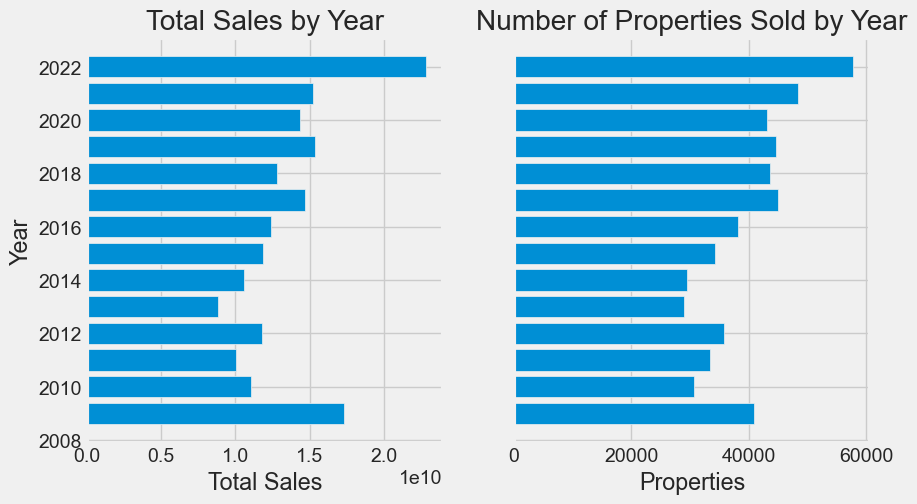

In [12]:
total_sales_per_year = df_train.groupby(by='Year').agg({'Sale Price':'sum'})

fig, ax = plt.subplots(1, 2, figsize=(9, 5), sharey=True)

ax[0].barh(total_sales_per_year.index,
           total_sales_per_year['Sale Price'])
ax[0].set_ylabel('Year')
ax[0].set_xlabel('Total Sales')
ax[0].set_title('Total Sales by Year')

ax[1].barh(df_train['Year'].value_counts().sort_index().index,
           df_train['Year'].value_counts().sort_index())
ax[1].set_xlabel('Properties')
ax[1].set_title('Number of Properties Sold by Year')

plt.show()

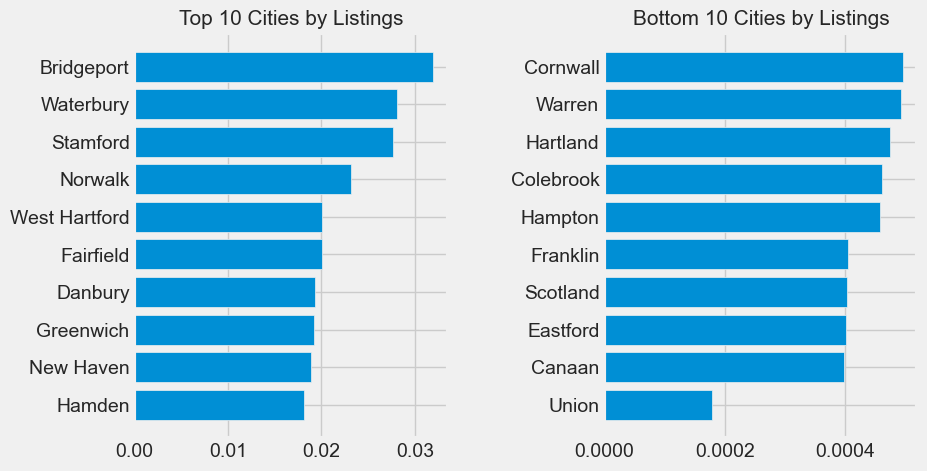

In [13]:
plt.figure(figsize=(9, 5))
plt.subplots_adjust(wspace=.5)

plt.subplot(1, 2, 1)
plt.barh(df_train['Locality'].value_counts(normalize=True).sort_values(ascending=False).index[:10],
         df_train['Locality'].value_counts(normalize=True).sort_values(ascending=False)[:10])
plt.gca().invert_yaxis()
plt.title('Top 10 Cities by Listings', fontsize=15)

plt.subplot(1, 2, 2)
plt.barh(df_train['Locality'].value_counts(normalize=True).sort_values(ascending=False).index[-10:],
         df_train['Locality'].value_counts(normalize=True).sort_values(ascending=False)[-10:])
plt.gca().invert_yaxis()
plt.title('Bottom 10 Cities by Listings', fontsize=15)

plt.show()

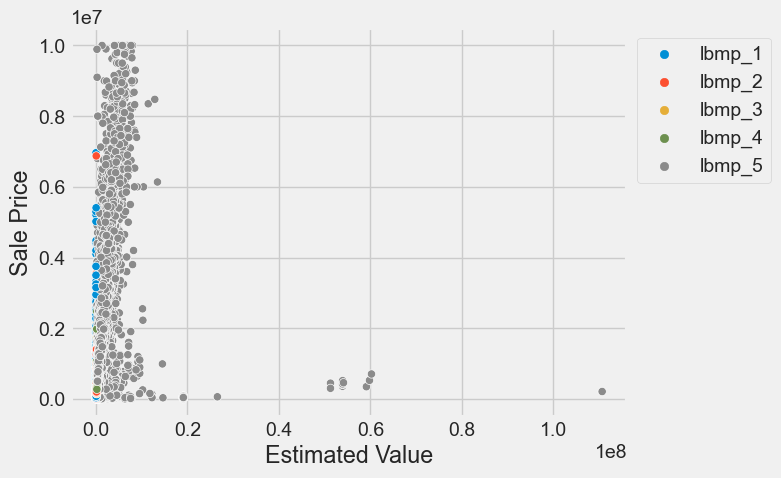

In [14]:
sns.scatterplot(data=df_train, x='Estimated Value',
                y='Sale Price', hue='locality_by_median_price')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

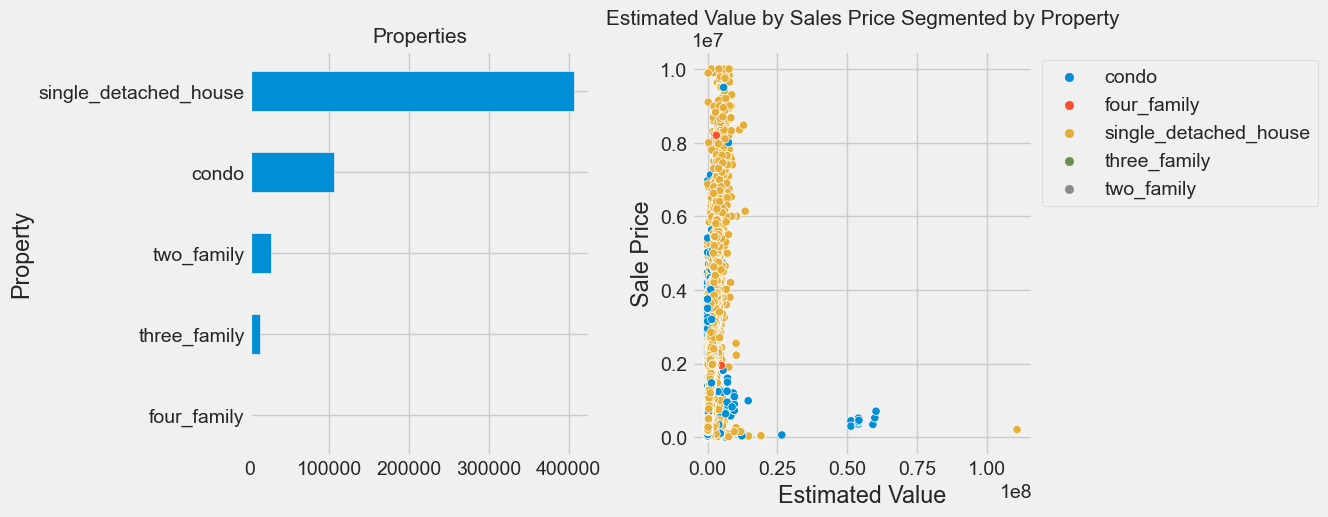

In [15]:
plt.figure(figsize=(9, 5))
plt.subplots_adjust(wspace=.3)

plt.subplot(1, 2, 1)
df_train['Property'].value_counts().plot.barh().invert_yaxis()
plt.title('Properties', fontsize=15)

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_train,
                x='Estimated Value',
                y='Sale Price',
                hue='Property')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Estimated Value by Sales Price Segmented by Property', fontsize=15)
plt.show()

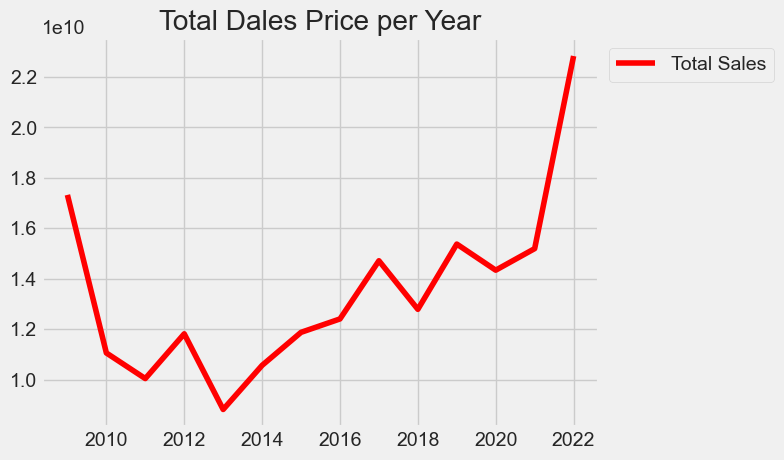

In [16]:
plt.plot(df_train.groupby(by=df_train.Date.dt.year).agg(
    {'Sale Price': np.sum}), color='red',
    label='Total Sales')
plt.title("Total Dales Price per Year")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

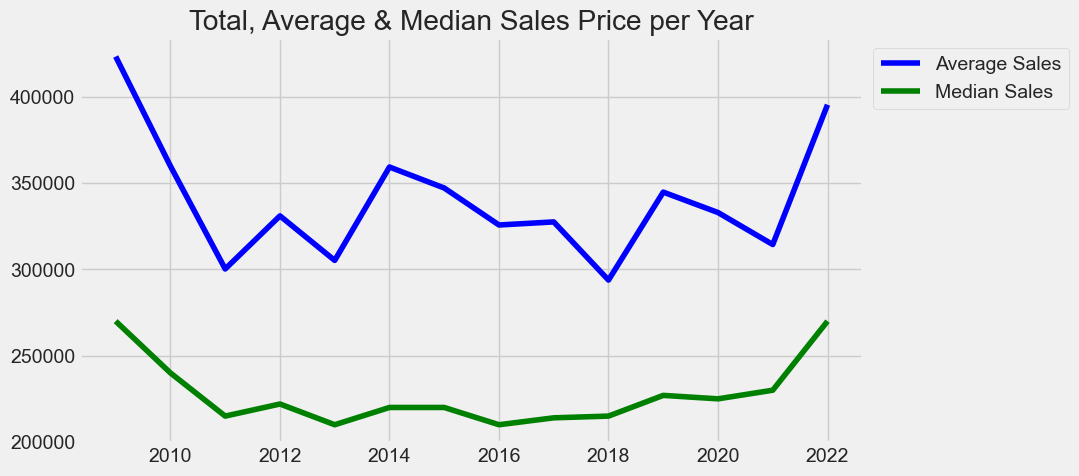

In [17]:
plt.figure(figsize=(9, 5))

plt.plot(df_train.groupby(by=df_train.Date.dt.year).agg(
    {'Sale Price': np.mean}), color='blue',
    label='Average Sales')
plt.plot(df_train.groupby(by=df_train.Date.dt.year).agg(
    {'Sale Price': np.median}), color='green',
    label='Median Sales')
plt.title('Total, Average & Median Sales Price per Year')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

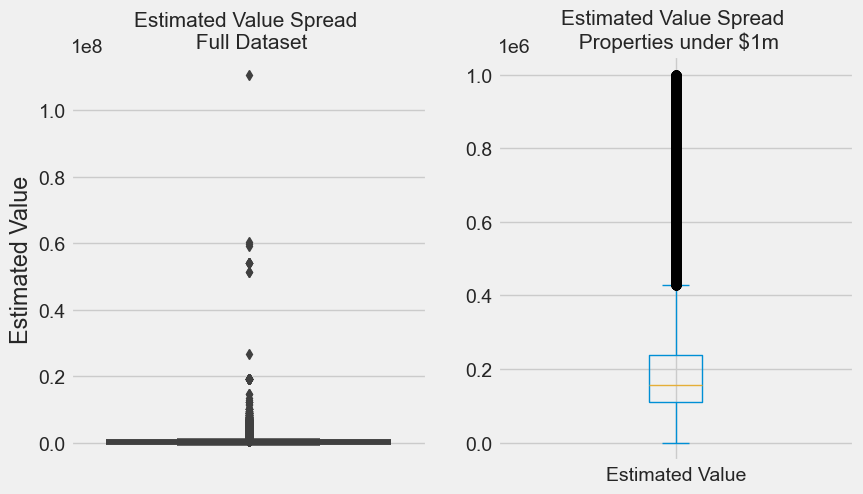

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(9, 5))

sns.boxplot(data=df_train, y='Estimated Value', ax=ax[0])
ax[0].set_title('Estimated Value Spread \n Full Dataset',
                fontsize=15)

df_train.loc[df_train['Estimated Value'] < 1e6, 'Estimated Value'].plot(kind='box', ax=ax[1])
ax[1].set_title('Estimated Value Spread \n Properties under $1m',
                fontsize=15)

plt.show()

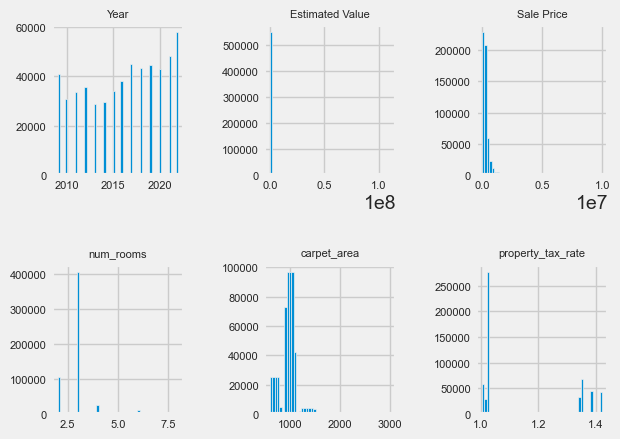

In [19]:
num_cols = ['Year', 'Estimated Value', 'Sale Price',
            'num_rooms', 'carpet_area', 'property_tax_rate']

fig = plt.figure()
fig.subplots_adjust(hspace=0.6, wspace=0.6)

for i, col in zip(range(1, 7), num_cols):
    ax = fig.add_subplot(2, 3, i)
    ax.hist(df_train[col], bins=50)
    ax.set_title(col, fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=6)

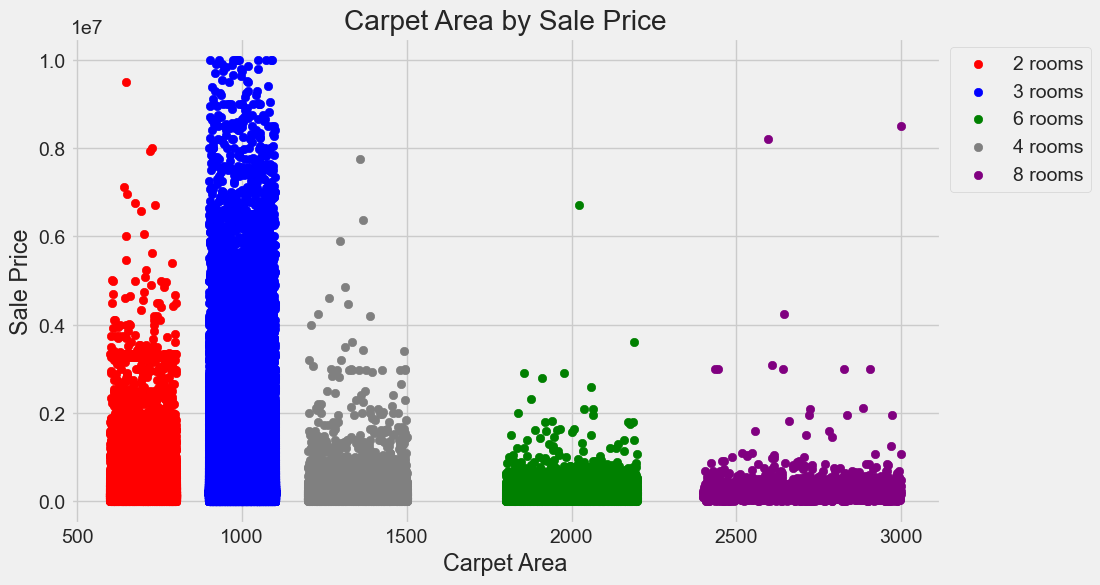

In [20]:
# Carpet Area by Sale Price
plt.figure(figsize=(10,6))

plt.scatter(df_train.loc[df_train.num_rooms == df_train.num_rooms.unique()[0], 'carpet_area'], df_train.loc[df_train.num_rooms == df_train.num_rooms.unique()[0], 'Sale Price'], c='red', label='2 rooms')
plt.scatter(df_train.loc[df_train.num_rooms == df_train.num_rooms.unique()[1], 'carpet_area'], df_train.loc[df_train.num_rooms == df_train.num_rooms.unique()[1], 'Sale Price'], c='blue', label='3 rooms')
plt.scatter(df_train.loc[df_train.num_rooms == df_train.num_rooms.unique()[2], 'carpet_area'], df_train.loc[df_train.num_rooms == df_train.num_rooms.unique()[2], 'Sale Price'], c='green', label='6 rooms')
plt.scatter(df_train.loc[df_train.num_rooms == df_train.num_rooms.unique()[3], 'carpet_area'], df_train.loc[df_train.num_rooms == df_train.num_rooms.unique()[3], 'Sale Price'], c='grey', label='4 rooms')
plt.scatter(df_train.loc[df_train.num_rooms == df_train.num_rooms.unique()[4], 'carpet_area'], df_train.loc[df_train.num_rooms == df_train.num_rooms.unique()[4], 'Sale Price'], c='purple', label='8 rooms')
plt.xlabel('Carpet Area')
plt.ylabel('Sale Price')
plt.title('Carpet Area by Sale Price')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

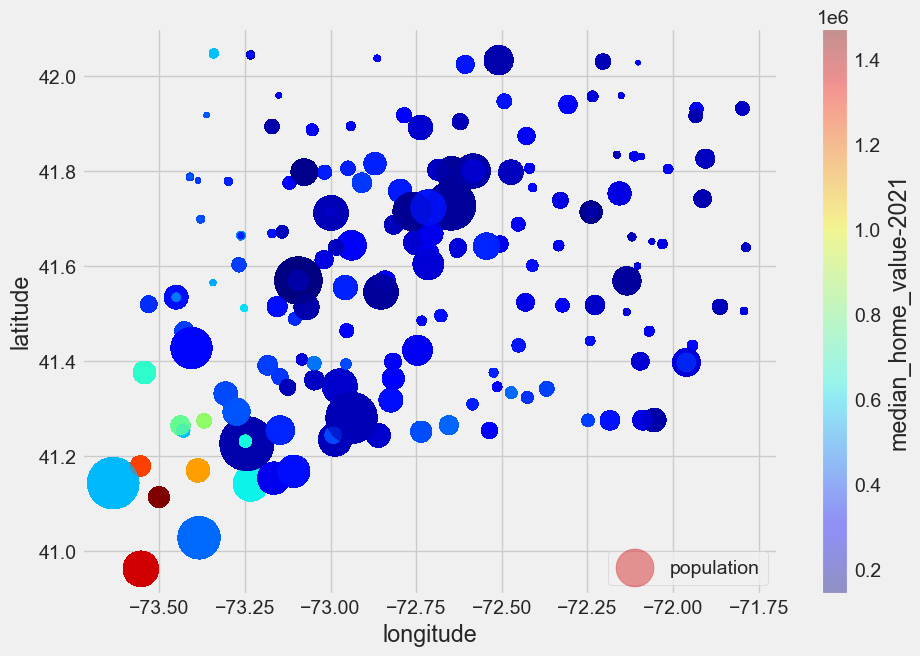

In [21]:
df_train.plot(kind='scatter', x='longitude', y='latitude',
         alpha=0.4, s=df_train['total_population-2021']/100,
         label='population', figsize=(10, 7),
         c='median_home_value-2021',
         cmap=mpl.colormaps.get_cmap("jet"), colorbar=True,
         grid=True,  legend=True, sharex=False)
plt.legend()
plt.show()

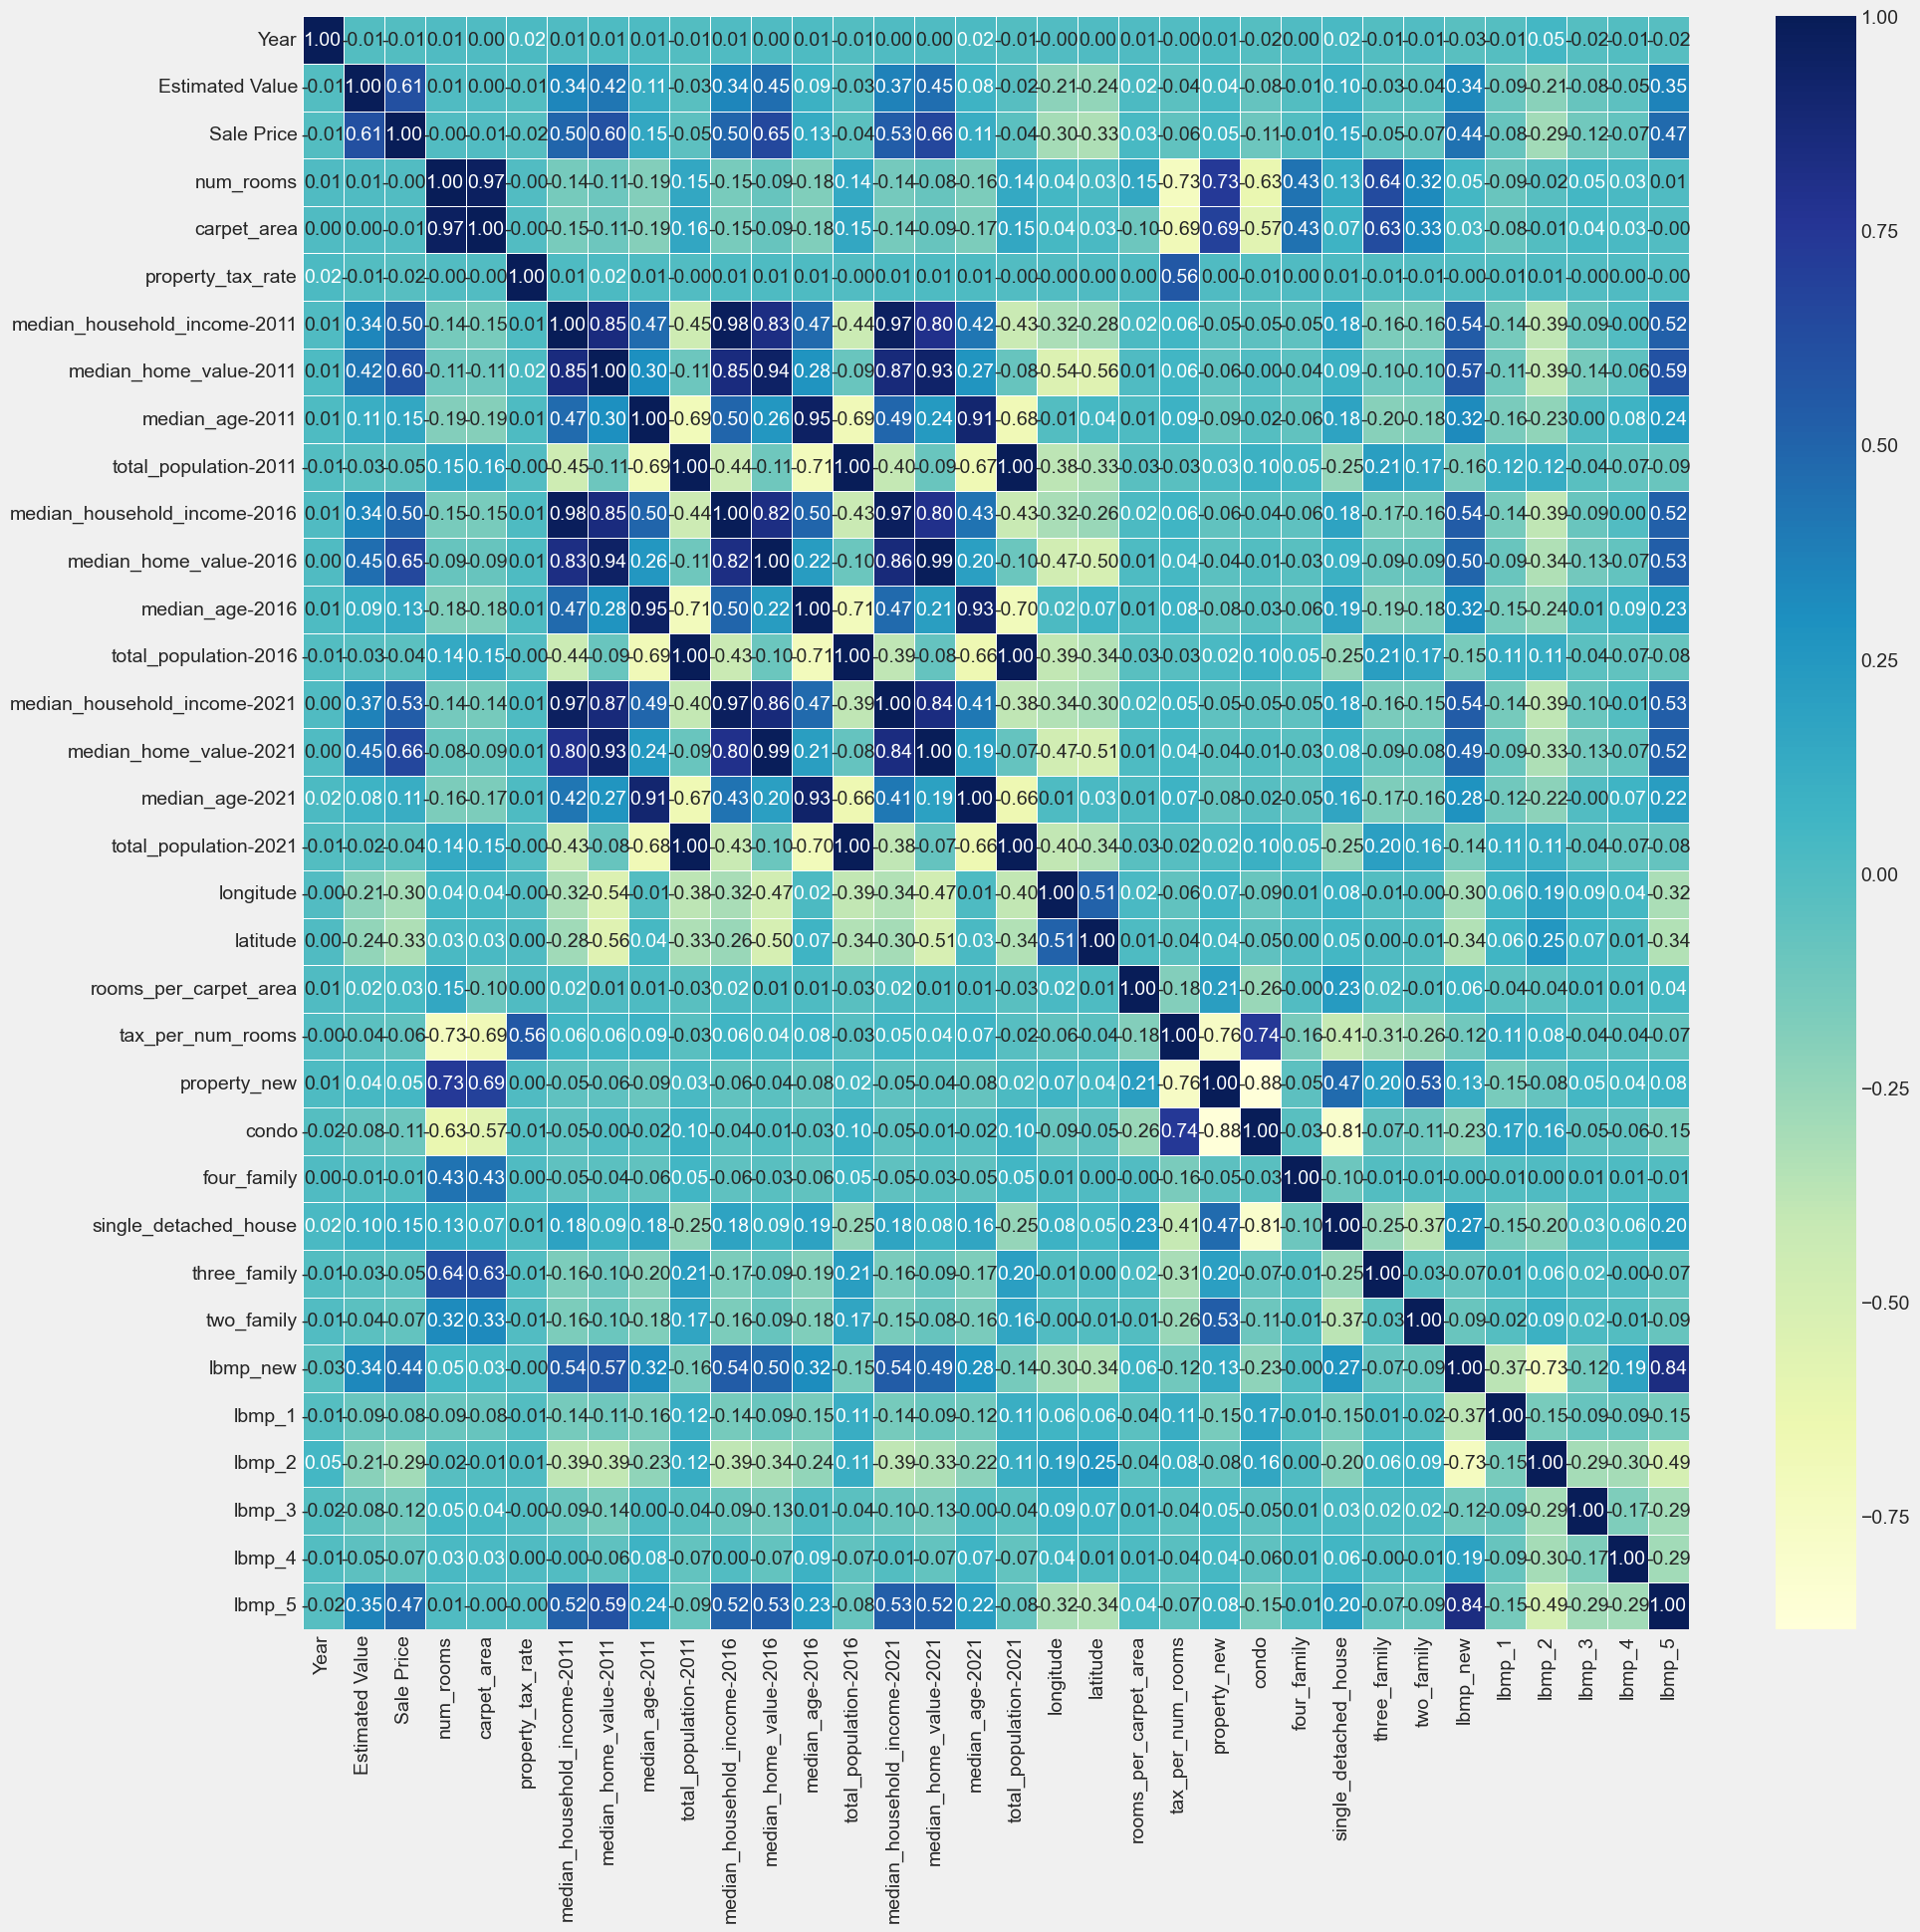

In [22]:
num_cols = list(df_train.columns)
del num_cols[1:4]
del num_cols[3:5]
num_cols.pop(6)

corr_matrix = df_train[num_cols].corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix,
            annot=True,
            linewidths=0.5,
            fmt= ".2f",
            cmap="YlGnBu");

In [ ]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.8, wspace=0.6)

for i, col in zip(range(1, 28), num_cols):
    ax = fig.add_subplot(7, 4, i)
    ax.hist(df_train[col], bins=50)
    ax.set_title(col, fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=6)

plt.tight_layout()
plt.show()

### Training & Evaluation of Machine Learning Models

In [24]:
df_train.drop(columns=['Locality', 'Address', 'Property',
                       'Residential', 'locality_by_median_price',
                       'property_new', 'lbmp_new'], inplace=True)

In [25]:
X = df_train.drop(columns=['Sale Price'])
y = df_train['Sale Price']
X_train = X.loc[X['Year'] != 2022].drop(columns='Date')
y_train = y.loc[X_train.index]

X_test = X.loc[X['Year'] == 2022].drop(columns='Date')
y_test = y.loc[X_test.index]
print(X_train.shape[0], X_test.shape[0])

495832 57740


In [26]:
# Standardiing the Features
scaler = StandardScaler().set_output(transform='pandas')
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [28]:
models = {'Extra Trees': ExtraTreesRegressor(),
          'Gradient Boost': GradientBoostingRegressor(),
          'XGBoost': XGBRegressor(),
          'LightGBM': LGBMRegressor()}

maes = list()
rmses = list()

for i in range(len(list(models.keys()))):
    model = list(models.values())[i]

    # Train Model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Evaluate model

    model_mse = mean_squared_error(y_test, y_pred)
    model_rmse = mean_squared_error(y_test, y_pred, squared=False)
    model_mae = mean_absolute_error(y_test, y_pred)
    model_mape = mean_absolute_percentage_error(y_test, y_pred)
    model_r2 = r2_score(y_test, y_pred)

    maes.append(model_mae)
    rmses.append(model_rmse)

    print(list(models.keys())[i])
    print(f'MSE: {model_mse:.6f}')
    print(f'RMSE: {model_rmse:.6f}')
    print(f'MAE: {model_mae:.6f}')
    print(f'MAPE: {model_mape:.2f}')
    print(f'R-squared: {model_r2:.2f}')
    # print(f'Adjusted R-squared: {model_adjusted_r2:.2f}')

    print('='*35)
    print('\n')

print(f'Average MAE across Models: {np.mean(maes):.4f}')
print(f'Average RMSE across Models: {np.mean(rmses):.4f}')


Extra Trees
MSE: 61086274777.115356
RMSE: 247156.377173
MAE: 111612.081959
MAPE: 0.44
R-squared: 0.76


Gradient Boost
MSE: 61942192670.985245
RMSE: 248881.884980
MAE: 112266.866516
MAPE: 0.44
R-squared: 0.76


XGBoost
MSE: 58056955969.333450
RMSE: 240950.110955
MAE: 111119.351532
MAPE: 0.44
R-squared: 0.77


LightGBM
MSE: 57749888640.340797
RMSE: 240312.065116
MAE: 107366.376148
MAPE: 0.42
R-squared: 0.77


Average MAE across Models: 110591.1690
Average RMSE across Models: 244325.1096


In [29]:
et_features = pd.DataFrame([X_train_scaled.columns, models['Extra Trees'].feature_importances_]).T.sort_values(by=1, ascending=False).head().iloc[:, 0]
gb_features = pd.DataFrame([X_train_scaled.columns, models['Gradient Boost'].feature_importances_]).T.sort_values(by=1, ascending=False).head().iloc[:, 0]
xgb_features = pd.DataFrame([X_train_scaled.columns, models['XGBoost'].feature_importances_]).T.sort_values(by=1, ascending=False).head().iloc[:, 0]
lgbm_features = pd.DataFrame([X_train_scaled.columns, models['LightGBM'].feature_importances_]).T.sort_values(by=1, ascending=False).head().iloc[:, 0]

features = pd.concat([et_features, gb_features, xgb_features, lgbm_features], ignore_index=True).unique()


In [38]:
models = {'Extra Trees': ExtraTreesRegressor(),
          'Gradient Boost': GradientBoostingRegressor(),
          'XGBoost': XGBRegressor(),
          'LightGBM': LGBMRegressor()}

y_preds = dict()
maes = list()
rmses = list()

for i in range(len(list(models.keys()))):
    model = list(models.values())[i]

    # Train Model
    model.fit(X_train_scaled[features], y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled[features])
    y_preds[model] = y_pred

    # Evaluate model
    model_mse = mean_squared_error(y_test, y_pred)
    model_rmse = mean_squared_error(y_test, y_pred, squared=False)
    model_mae = mean_absolute_error(y_test, y_pred)
    model_mape = mean_absolute_percentage_error(y_test, y_pred)
    model_r2 = r2_score(y_test, y_pred)

    maes.append(model_mae)
    rmses.append(model_rmse)

    print(list(models.keys())[i])
    print(f'MSE: {model_mse:.6f}')
    print(f'RMSE: {model_rmse:.6f}')
    print(f'MAE: {model_mae:.6f}')
    print(f'MAPE: {model_mape:.2f}')
    print(f'R-squared: {model_r2:.2f}')


    print('='*35)
    print('\n')

print(f'Average MAE across Models: {np.mean(maes):.4f}')
print(f'Average RMSE across Models: {np.mean(rmses):.4f}')


Extra Trees
MSE: 62842735393.758865
RMSE: 250684.533615
MAE: 114314.272380
MAPE: 0.45
R-squared: 0.75


Gradient Boost
MSE: 60866981400.394806
RMSE: 246712.345456
MAE: 112094.323281
MAPE: 0.42
R-squared: 0.76


XGBoost
MSE: 57877684378.690186
RMSE: 240577.813563
MAE: 109996.533428
MAPE: 0.42
R-squared: 0.77


LightGBM
MSE: 56876583044.710228
RMSE: 238488.119295
MAE: 107728.116842
MAPE: 0.41
R-squared: 0.78


Average MAE across Models: 111033.3115
Average RMSE across Models: 244115.7030


In [39]:
from scipy import stats
confidence = 0.95

for key, val in y_preds.items():
    print(key)
    squared_errors = (val - y_test) ** 2
    ci_95 = np.sqrt(stats.t.interval(confidence, 
                                     len(squared_errors) - 1,
                                     loc=squared_errors.mean(),
                                     scale=stats.sem(squared_errors)))
    print(f'95% confidence interval for model is {ci_95}')
    print('='*35)
    print('\n')

ExtraTreesRegressor()
95% confidence interval for model is [240165.92887677 260779.21196728]


GradientBoostingRegressor()
95% confidence interval for model is [236784.67273999 256255.69565612]


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
95% confidence interval for model is [230062.4043593  250652.46

/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_78694/233103397.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axi.set_xticklabels(labels=labels, rotation=35)


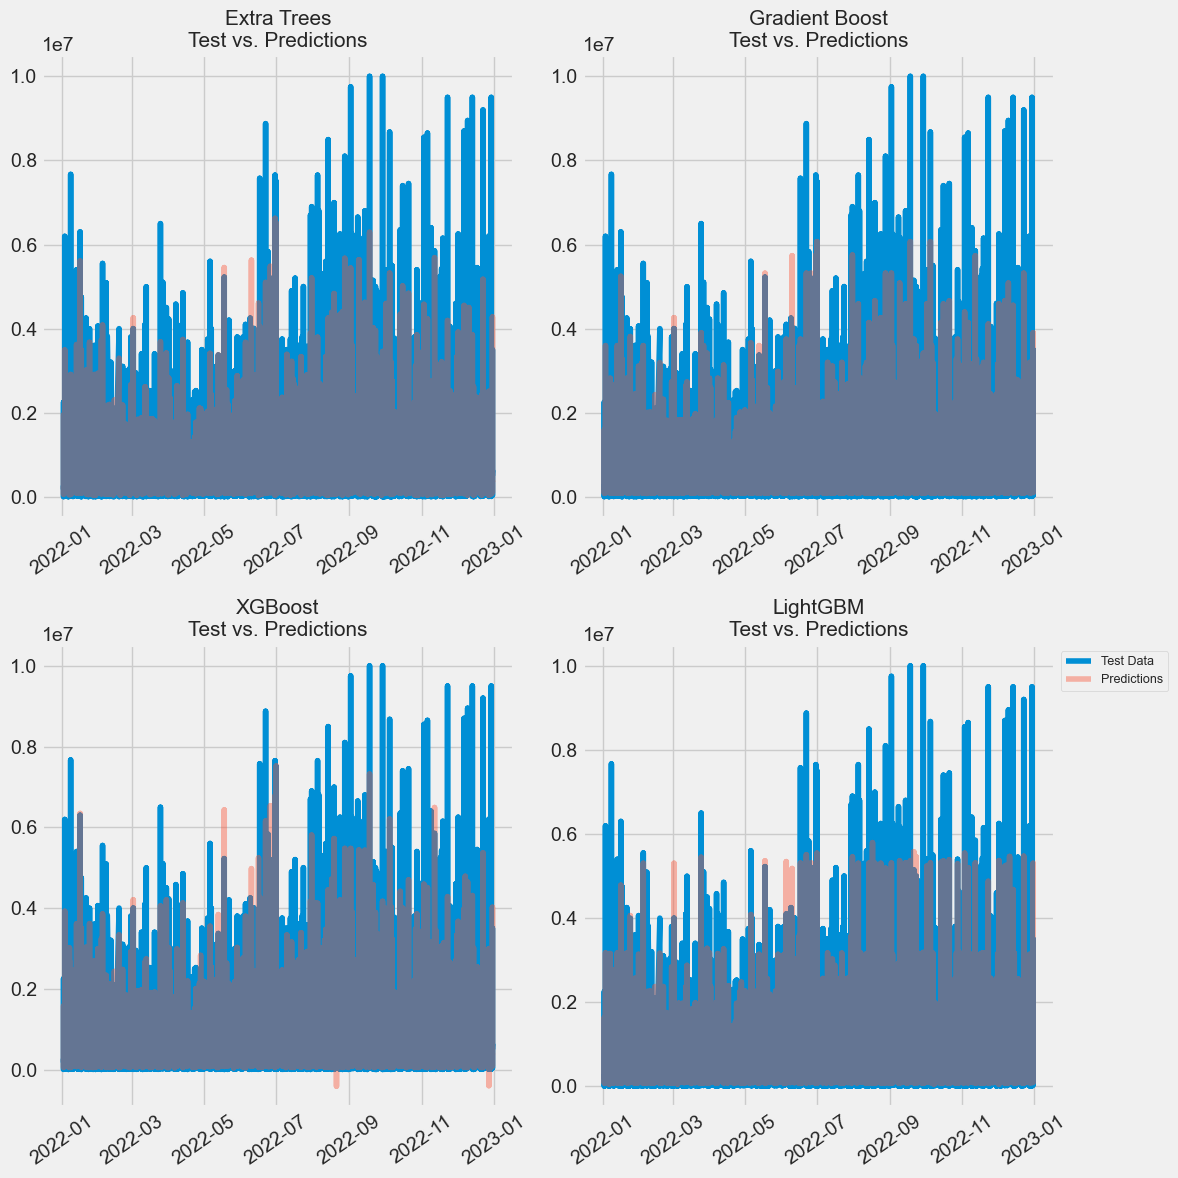

In [40]:
model_names = list(models.keys())

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

for axi, model, num in zip(ax.flat, model_names, range(len(model_names))):
    axi.plot(X.loc[X_test.index, 'Date'], y_test)
    axi.plot(X.loc[X_test.index, 'Date'],
             list(y_preds.values())[num], alpha=.4)
    labels = axi.get_xticklabels()
    axi.set_xticklabels(labels=labels, rotation=35)
    axi.set_title(f'{model}\nTest vs. Predictions', fontsize=15)

plt.legend(['Test Data', 'Predictions'], loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)
plt.tight_layout()
plt.show()

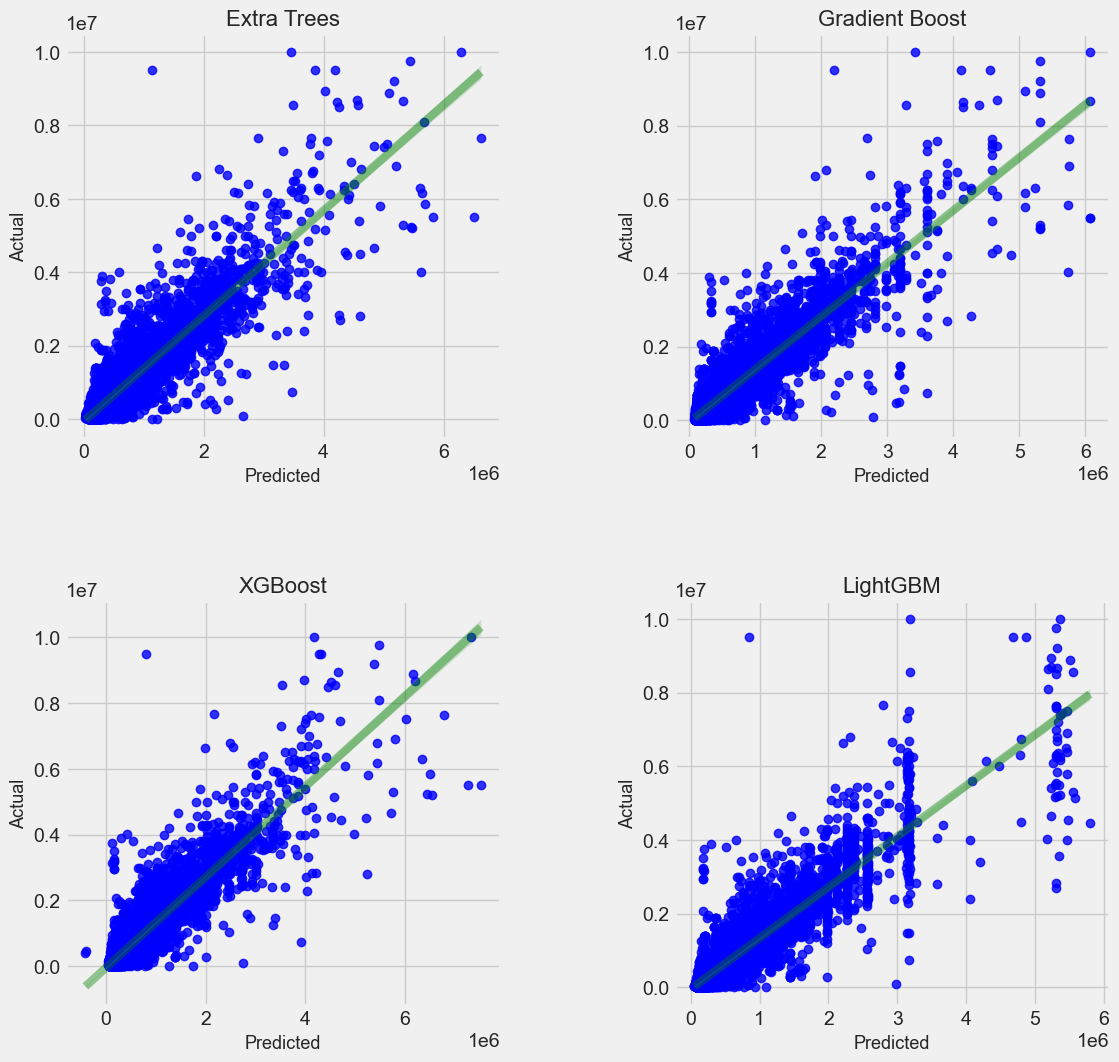

In [41]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for axi, pred, name in zip(ax.flat, y_preds.values(), model_names):
    sns.regplot(x=pred, y=y_test, scatter_kws={"color": "blue"},
                line_kws={"color": "green", 'alpha':.4},
                ax=axi)
    axi.set_title(name, fontsize=16)
    axi.set_xlabel('Predicted', fontsize=13)
    axi.set_ylabel('Actual', fontsize=13)

plt.show()

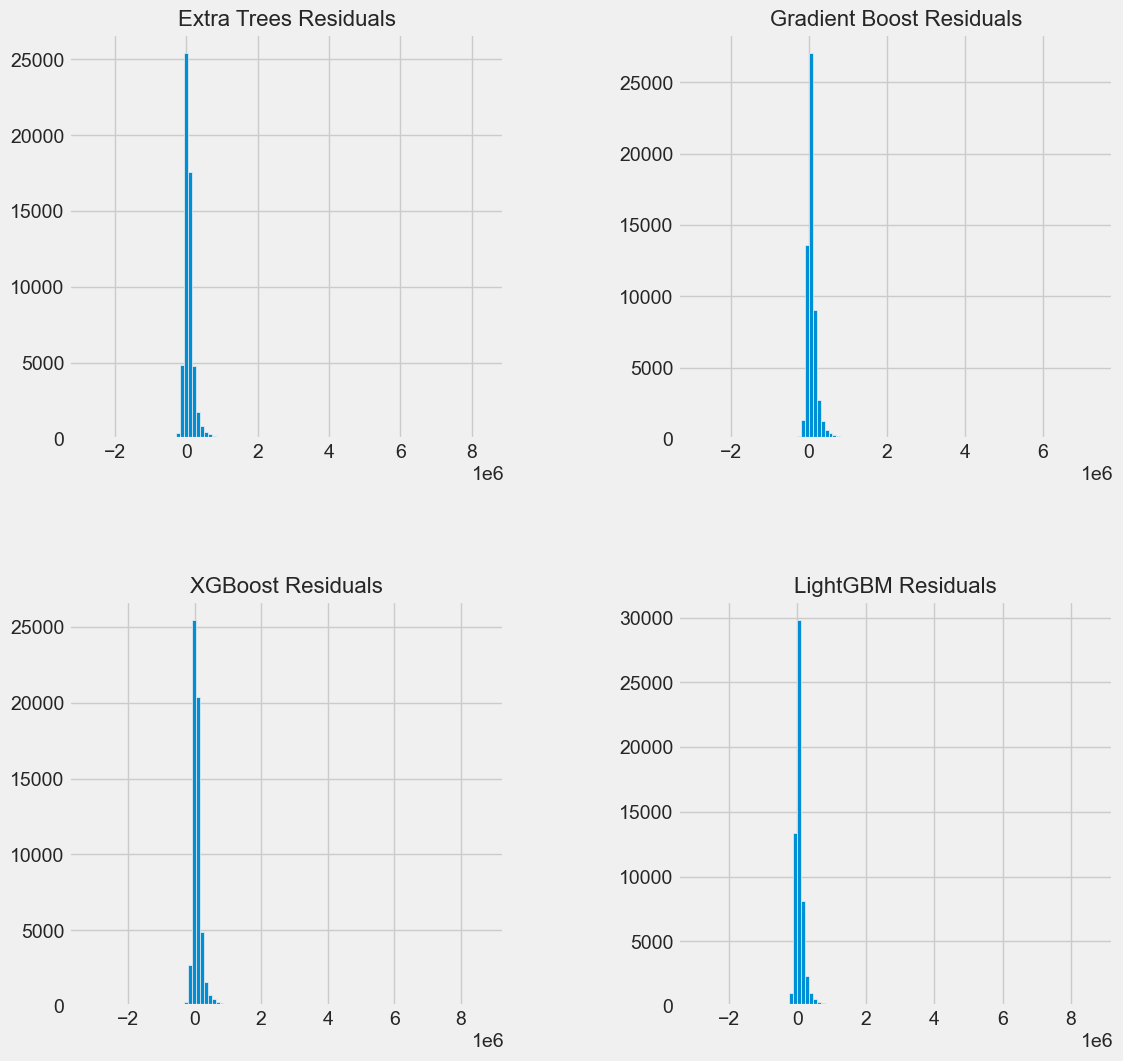

In [42]:
residuals = list()

for num in range(len(model_names)):
    residual = y_test - list(y_preds.values())[num]
    residuals.append(residual)

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for axi, residual, model in zip(ax.flat, residuals, model_names):
    axi.hist(residual, bins=100)
    axi.set_title(f'{model} Residuals', fontsize=16)

plt.show()

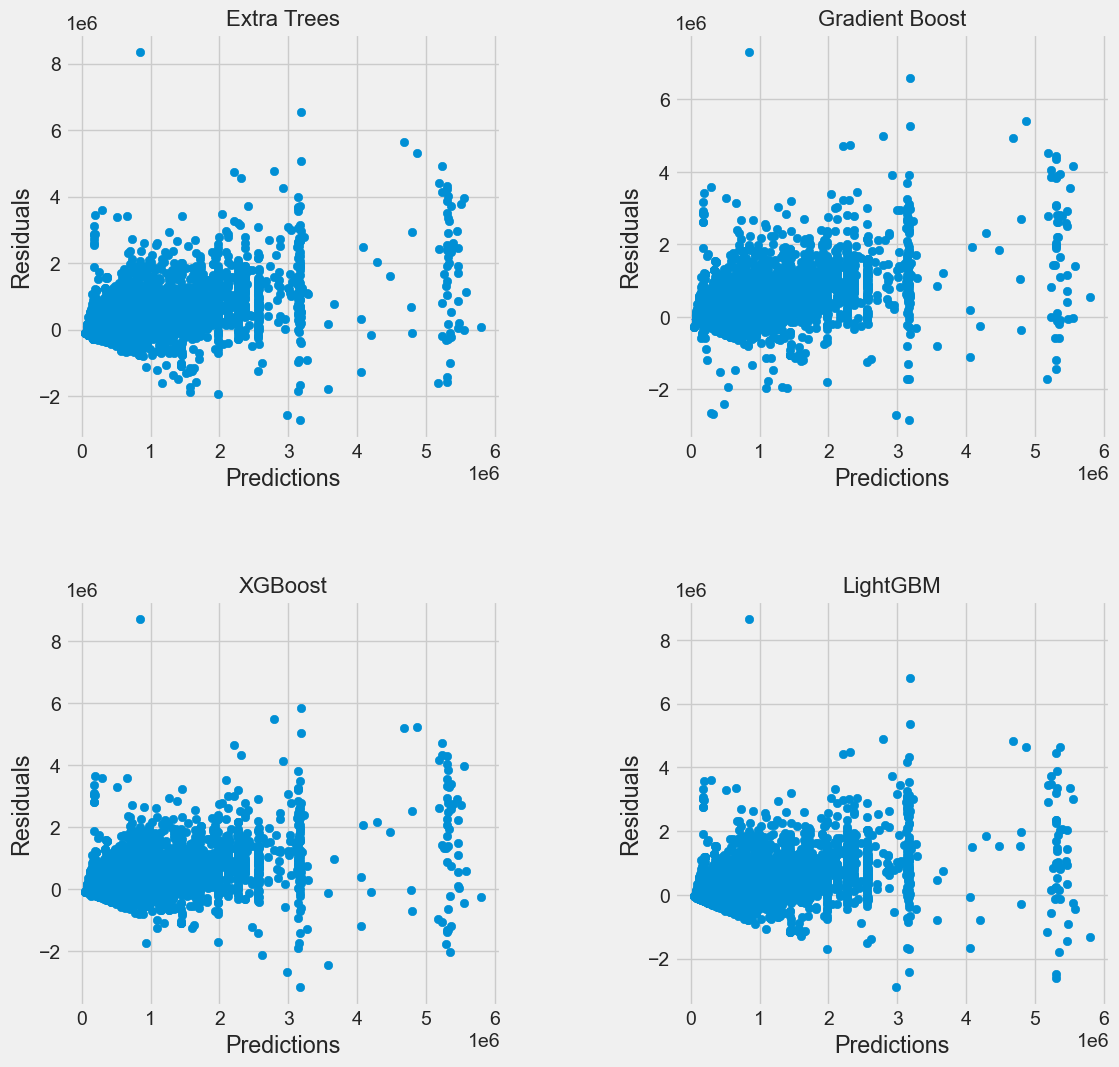

In [43]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for axi, residual, model in zip(ax.flat, residuals, model_names):
    axi.scatter(list(y_preds.values())[num], residual)
    axi.set_title(f'{model}', fontsize=16)
    axi.set_xlabel('Predictions')
    axi.set_ylabel('Residuals')

plt.show()

### Cross Validation

In [44]:
models = {'Extra Trees': ExtraTreesRegressor(),
          'Gradient Boost': GradientBoostingRegressor(),
          'XGBoost': XGBRegressor(),
          'LightGBM': LGBMRegressor()}

for key, model in models.items():
    scores = cross_val_score(model, X[features], y, cv=5,
                             scoring='neg_root_mean_squared_error')
    print(f'Model: {key}')
    print(f'RMSEs: {scores}')
    print(f'Avg. RMSEs: {np.mean(scores):.2f} (+/- {np.std(scores):.2f})')
    print('='*35)
    print('\n')

Model: Extra Trees
RMSEs: [-263262.28966051 -200662.49184676 -187452.49206061 -204613.5892266
 -189692.55558284]
Avg. RMSEs: -209136.68 (+/- 27821.32)


Model: Gradient Boost
RMSEs: [-251306.40817427 -188917.68059046 -183387.2470436  -199976.06142975
 -180153.40745674]
Avg. RMSEs: -200748.16 (+/- 26161.95)


Model: XGBoost
RMSEs: [-254773.37434246 -190764.30427833 -179526.76859401 -202799.7925765
 -183639.43237379]
Avg. RMSEs: -202300.73 (+/- 27399.32)


Model: LightGBM
RMSEs: [-253855.88369848 -194659.65483587 -183579.49568848 -200918.72257983
 -190076.62856367]
Avg. RMSEs: -204618.08 (+/- 25263.78)




In [47]:
# Stacking Ensemble
level0 = list()
level0.append(('extra_trees', ExtraTreesRegressor()))
level0.append(('gradient_boost', GradientBoostingRegressor()))
level0.append(('light_gbm', LGBMRegressor()))

# define meta learner model
level1 = XGBRegressor()

# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)

model.fit(X_train_scaled[features], y_train)
y_pred = model.predict(X_test_scaled[features])

model_mse = mean_squared_error(y_test, y_pred)
model_rmse = mean_squared_error(y_test, y_pred, squared=False)
model_mae = mean_absolute_error(y_test, y_pred)
model_mape = mean_absolute_percentage_error(y_test, y_pred)
model_r2 = r2_score(y_test, y_pred)

print(f'RMSE: {model_rmse:.2f}')
print(f'MAE: {model_mae:.2f}')

RMSE: 233857.52
MAE: 103955.93


/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_78694/3745187321.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=labels, rotation=35)


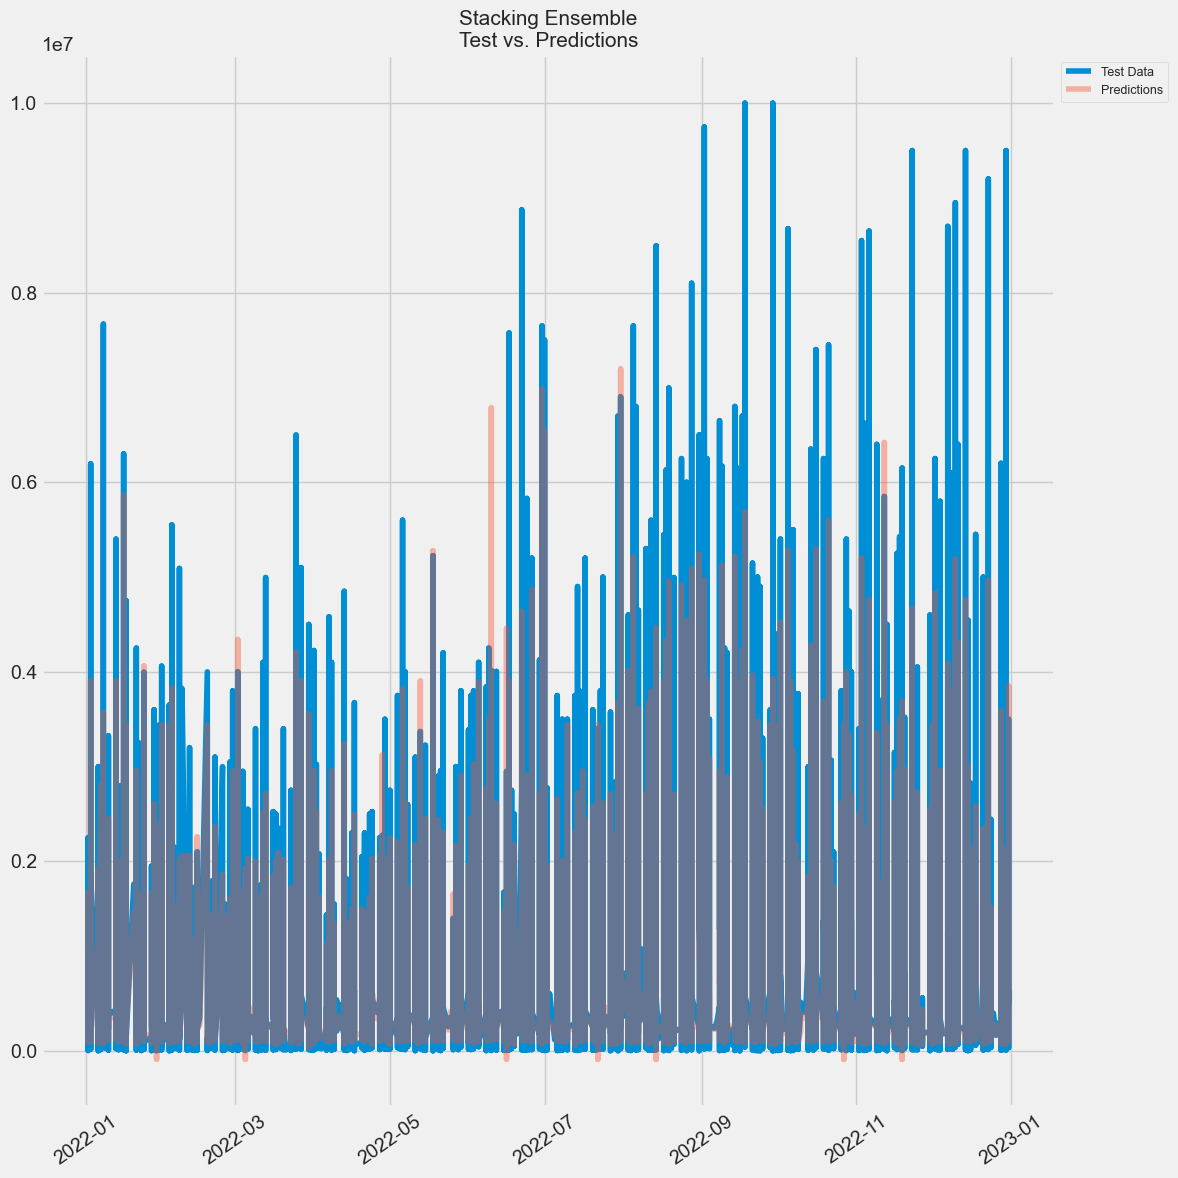

In [48]:
model_names = list(models.keys())

fig, ax = plt.subplots(figsize=(12, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

ax.plot(X.loc[X_test.index, 'Date'], y_test)
ax.plot(X.loc[X_test.index, 'Date'], y_pred, alpha=.4)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels=labels, rotation=35)
ax.set_title(f'Stacking Ensemble\nTest vs. Predictions', fontsize=15)
ax.legend(['Test Data', 'Predictions'], loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)

plt.tight_layout()
plt.show()

### Test Predictions

In [52]:
test = pd.read_csv('../datasets/the-great-real-estate-data-challenge/test.csv')

df_test = prepare_data(test)
df_test.drop(columns=['Locality', 'Address', 'Property',
                       'Residential', 'locality_by_median_price',
                       'property_new', 'lbmp_new'], inplace=True)

df_test.head()

,Year,Date,Estimated Value,Sale Price,num_rooms,carpet_area,property_tax_rate,Segment,median_household_income-2011,median_home_value-2011,...,condo,four_family,single_detached_house,three_family,two_family,lbmp_1,lbmp_2,lbmp_3,lbmp_4,lbmp_5
0,2023,2023-01-01,151400.0,0,3,947.0,1.46,0,113099,512603.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2023,2023-01-01,686900.0,0,3,1051.0,1.46,0,175053,854258.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2023,2023-01-04,152030.0,0,3,925.0,1.46,0,97095,309663.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2023,2023-01-04,156130.0,0,4,1210.0,1.46,0,47197,275980.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,2023,2023-01-04,108970.0,0,3,1089.0,1.46,0,96801,364472.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [53]:
scaler = StandardScaler().set_output(transform='pandas')
df_test_scaled = scaler.fit_transform(df_test.drop(columns=['Date', 'Sale Price', 'Segment']))

df_test_scaled.head()

,Year,Estimated Value,num_rooms,carpet_area,property_tax_rate,median_household_income-2011,median_home_value-2011,median_age-2011,total_population-2011,median_household_income-2016,...,condo,four_family,single_detached_house,three_family,two_family,lbmp_1,lbmp_2,lbmp_3,lbmp_4,lbmp_5
0,0.0,-0.092678,0.070131,-0.164239,-4.440892e-16,0.439251,0.454424,1.573228,-1.034824,0.154957,...,-0.515858,-0.068955,0.647537,-0.162074,-0.241069,-0.277184,-0.642550,2.328948,-0.399828,-0.722439
1,0.0,0.244180,0.070131,0.231112,-4.440892e-16,2.072145,2.086550,0.311931,-0.550425,1.901055,...,-0.515858,-0.068955,0.647537,-0.162074,-0.241069,-0.277184,-0.642550,-0.429378,-0.399828,1.384200
2,0.0,-0.092282,0.070131,-0.247871,-4.440892e-16,0.017440,-0.515045,0.710236,-0.852149,0.025416,...,-0.515858,-0.068955,0.647537,-0.162074,-0.241069,-0.277184,-0.642550,2.328948,-0.399828,-0.722439
3,0.0,-0.089703,1.349698,0.835544,-4.440892e-16,-1.297699,-0.675953,-2.343431,2.454309,-1.370828,...,-0.515858,-0.068955,-1.544314,-0.162074,4.148197,-0.277184,-0.642550,2.328948,-0.399828,-0.722439
4,0.0,-0.119369,0.070131,0.375568,-4.440892e-16,0.009692,-0.253216,-0.241269,-1.081124,0.050847,...,-0.515858,-0.068955,0.647537,-0.162074,-0.241069,-0.277184,1.556298,-0.429378,-0.399828,-0.722439


In [54]:
predictions = model.predict(df_test_scaled[features])

/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_78694/481843276.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=labels, rotation=35)


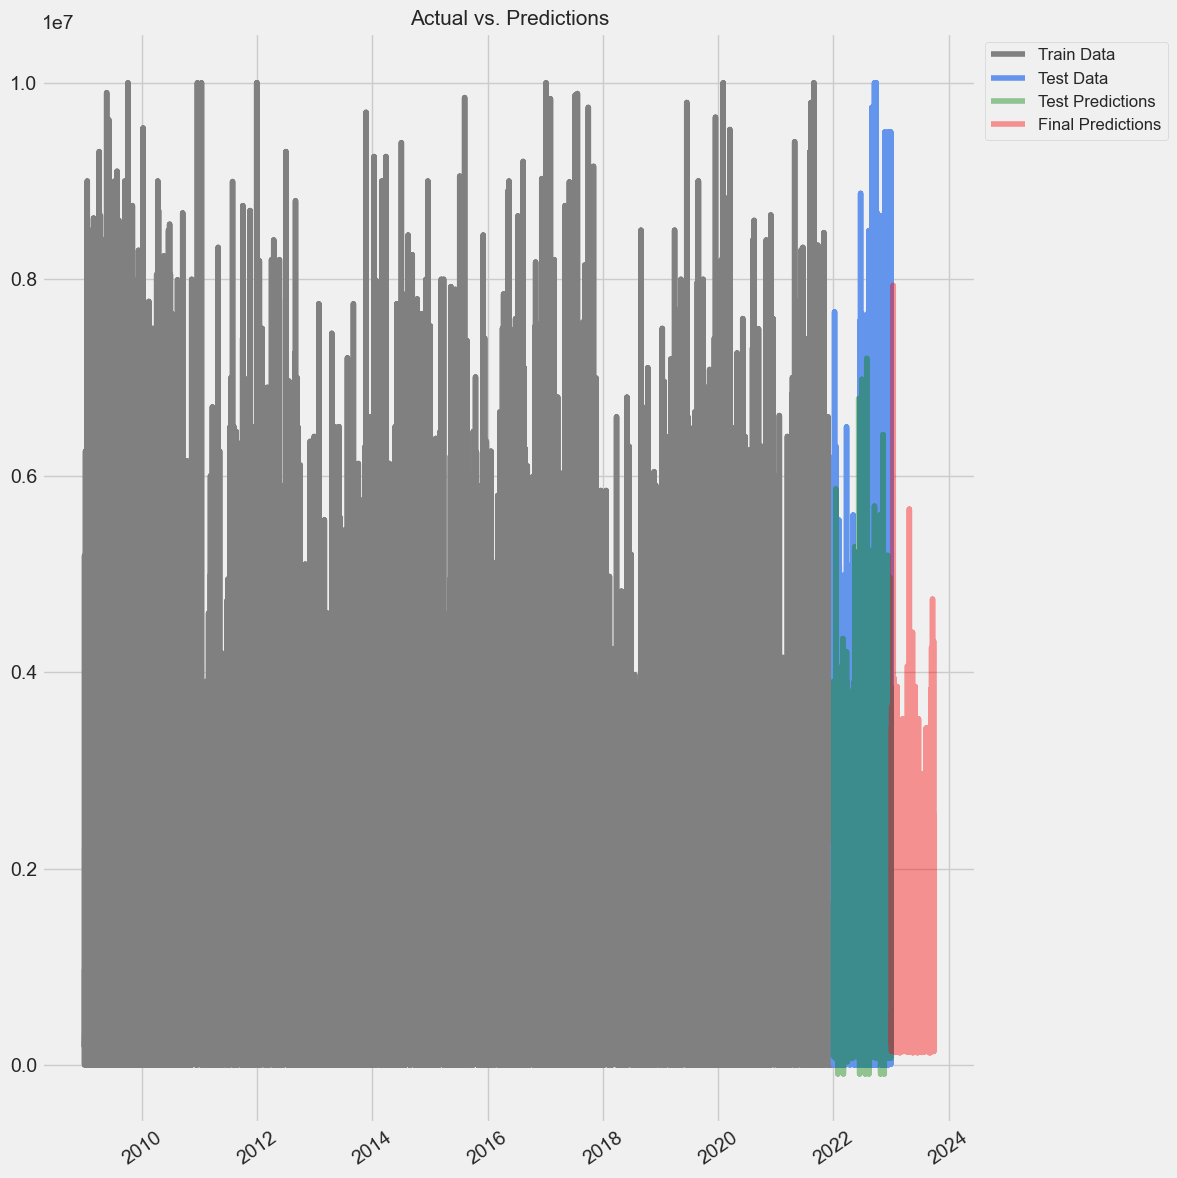

In [55]:
fig, ax = plt.subplots(figsize=(12, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

ax.plot(X.loc[X_train.index, 'Date'], y_train, c='grey')
ax.plot(X.loc[X_test.index, 'Date'], y_test, c='cornflowerblue')
ax.plot(X.loc[X_test.index, 'Date'], y_pred, alpha=.4, c='green')
ax.plot(df_test.loc[df_test.index, 'Date'], predictions, alpha=.4, c='red')
labels = ax.get_xticklabels()
ax.set_xticklabels(labels=labels, rotation=35)
ax.set_title(f'Actual vs. Predictions', fontsize=15)
ax.legend(['Train Data', 'Test Data', 'Test Predictions',
           'Final Predictions'],
          loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

plt.tight_layout()
plt.show()

In [56]:
df_test['Sale Price'] = predictions
df_test['Sale Price'] = df_test['Sale Price'].apply(lambda x: f'{x:.2f}')
df_test.head()

,Year,Date,Estimated Value,Sale Price,num_rooms,carpet_area,property_tax_rate,Segment,median_household_income-2011,median_home_value-2011,...,condo,four_family,single_detached_house,three_family,two_family,lbmp_1,lbmp_2,lbmp_3,lbmp_4,lbmp_5
0,2023,2023-01-01,151400.0,275476.06,3,947.0,1.46,0,113099,512603.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2023,2023-01-01,686900.0,518213.44,3,1051.0,1.46,0,175053,854258.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2023,2023-01-04,152030.0,272086.25,3,925.0,1.46,0,97095,309663.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2023,2023-01-04,156130.0,236236.72,4,1210.0,1.46,0,47197,275980.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,2023,2023-01-04,108970.0,253716.78,3,1089.0,1.46,0,96801,364472.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
